# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [28]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

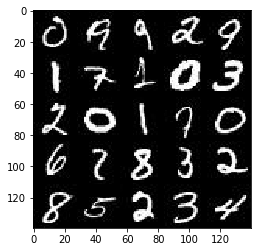

In [29]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

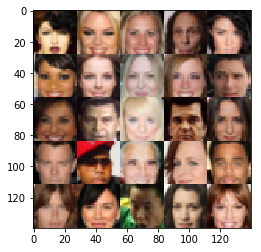

In [30]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [66]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32)

    return real_image, z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [67]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
#     alpha = 0.2
#     with tf.variable_scope('discriminator', reuse=reuse):
#         # 14*14*128
#         conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
#         relu1 = tf.maximum(alpha*conv1, conv1)
        
#         # 7*7*256
#         conv2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
#         norm2 = tf.layers.batch_normalization(conv2, training=True)
#         relu2 = tf.maximum(alpha*norm2, norm2)
        
#         # 4*4*512
#         conv3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
#         norm3 = tf.layers.batch_normalization(conv3, training=True)
#         relu3 = tf.maximum(alpha*norm3, norm3)
        
#         # 2*2*512
#         #conv4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
#         #norm4 = tf.layers.batch_normalization(conv4, training=True)
#         #relu4 = tf.maximum(alpha*norm4, norm4)
        
#         flat = tf.reshape(relu3, (-1, 4, 4, 512))
#         logits = tf.layers.dense(flat, 1)
#         out = tf.sigmoid(logits)
        
#     return out, logits

    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
     
        # 14 x 14 x 64
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        # 7 x 7 x 128
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        
        # 4 x 4 x 256
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        
        # 2 x 2 x 512
        conv4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        norm4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha * norm4, norm4)
                
        reshape = tf.reshape(relu4,(-1, 8 * 64 * 2 * 2))
        logits = tf.layers.dense(reshape, 1)
        out = tf.sigmoid(logits)
     
    return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [68]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    with tf.variable_scope('generator', reuse = not is_train):
#         fcon1 = tf.layers.dense(z, 4*4*512)
#         x1 = tf.reshape(fcon1, (-1, 4, 4, 512))
#         norm1 = tf.layers.batch_normalization(x1, training=is_train)
#         relu1 = tf.maximum(alpha*norm1, norm1)
        
#         # 7*7*256
#         resize2 = tf.image.resize_nearest_neighbor(relu1, (7,7))
#         convt2 = tf.layers.conv2d(resize2, 256, 5, padding='same')
#         norm2 = tf.layers.batch_normalization(convt2, training=is_train)
#         relu2 = tf.maximum(alpha*norm2, norm2)
        
#         #14*14*128
#         resize3 = tf.image.resize_nearest_neighbor(relu2, (14,14))
#         convt3 = tf.layers.conv2d(resize3, 128, 5, padding='same')
#         norm3 = tf.layers.batch_normalization(convt3, training=is_train)
#         relu3 = tf.maximum(alpha*norm3, norm3)
        
#         # 28*28*out_channel_dim
#         resize4 = tf.image.resize_nearest_neighbor(relu2, (28,28))
#         logits = tf.layers.conv2d(resize4, out_channel_dim, 5, padding='same')
#         out = tf.tanh(logits)

        fcon1 = tf.layers.dense(z, 16 * 32 * 3 * 3)
        x1 = tf.reshape(fcon1, (-1, 3, 3, 16 * 32))
        norm1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * norm1, norm1)

        # 7 x 7 x 128
        convt2 = tf.layers.conv2d_transpose(relu1, 128, 3, strides=2, padding='valid')
        norm2 = tf.layers.batch_normalization(convt2, training=is_train)
        relu2 = tf.maximum(alpha * norm2, norm2)

        # 14 x 14 x 64 
        convt3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        norm3 = tf.layers.batch_normalization(convt3, training=is_train)
        relu3 = tf.maximum(alpha * norm3, norm3)

        # 28 x 28 x 32
        convt4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same')
        norm4 = tf.layers.batch_normalization(convt4, training=is_train)
        relu4 = tf.maximum(alpha * norm4, norm4)

        # 28 x 28 x out_channel_dim
        convt5 = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(convt5)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [69]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [70]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [71]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [72]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images.reshape(batch_size, 
                                                    data_shape[1], 
                                                    data_shape[2],
                                                    data_shape[3])
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size = (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict = {input_real:batch_images, 
                                                 input_z:batch_z,
                                                 lr:learning_rate
                                                 })
                _ = sess.run(g_opt, feed_dict = {input_real:batch_images,
                                                 input_z:batch_z,
                                                 lr:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z})
                    
                    losses.append((train_loss_d,train_loss_g))
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.3637
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.3744
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 3.2198
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 1.7559


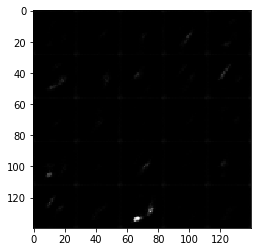

Epoch 1/2... Discriminator Loss: 1.9667... Generator Loss: 5.2876
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.5249
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 1.7306
Epoch 1/2... Discriminator Loss: 1.9006... Generator Loss: 0.3145
Epoch 1/2... Discriminator Loss: 2.4877... Generator Loss: 0.1730
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.7888


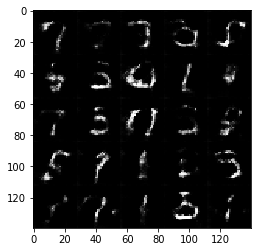

Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.7829
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 1.9712
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 3.1288
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 2.8870
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.9698


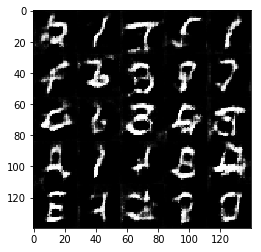

Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 1.6856
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.8771
Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.3064
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 2.4529
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 0.8562


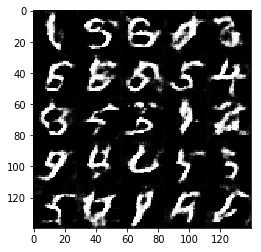

Epoch 1/2... Discriminator Loss: 1.8451... Generator Loss: 0.3200
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 0.9553
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.5698... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.0482
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.8426


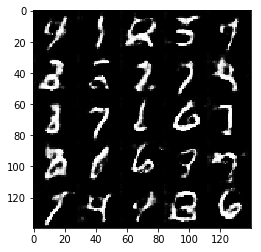

Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 2.0122... Generator Loss: 0.2392
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.5953
Epoch 1/2... Discriminator Loss: 0.8091... Generator Loss: 1.2335
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.3534
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.4106
Epoch 1/2... Discriminator Loss: 0.9231... Generator Loss: 1.0011


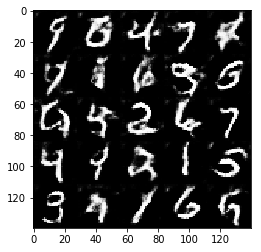

Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 1.9675... Generator Loss: 0.2643
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.6529
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.6171
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.1310


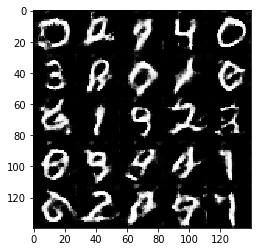

Epoch 1/2... Discriminator Loss: 1.8420... Generator Loss: 0.3629
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.6687
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.5472
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.9084
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.7374


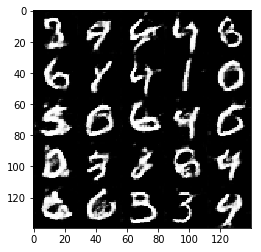

Epoch 1/2... Discriminator Loss: 1.5774... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 2.4186
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.7771
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 2.0496
Epoch 1/2... Discriminator Loss: 2.3045... Generator Loss: 0.1908
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.7790


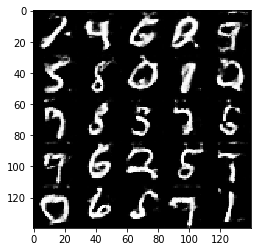

Epoch 1/2... Discriminator Loss: 2.1858... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.1155... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.5161
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.1571
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 2.3712
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.0558


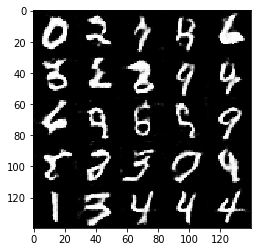

Epoch 1/2... Discriminator Loss: 1.0007... Generator Loss: 2.3128
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 1.1379... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 2.3051... Generator Loss: 0.2274
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 2.0958... Generator Loss: 0.3166
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.8095


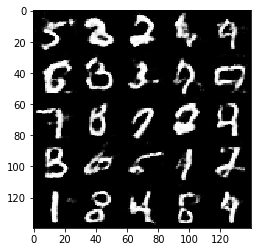

Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 0.8999
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.8377
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 1.7165... Generator Loss: 0.3348
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 1.1523... Generator Loss: 0.9556
Epoch 1/2... Discriminator Loss: 1.8842... Generator Loss: 0.2975
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.5478


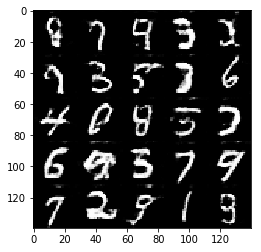

Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.8937
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 1.0844
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 1.9909... Generator Loss: 0.2593
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 1.8704... Generator Loss: 0.3137
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.8822


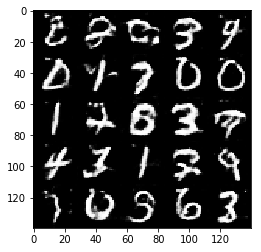

Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.8185... Generator Loss: 1.0970
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.8612... Generator Loss: 0.3046
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.4881
Epoch 1/2... Discriminator Loss: 2.4582... Generator Loss: 0.1756
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.4194
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 2.2947... Generator Loss: 0.2007


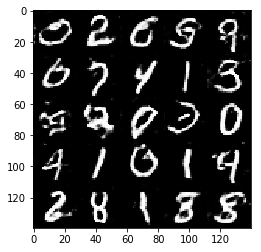

Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.7479
Epoch 1/2... Discriminator Loss: 1.7736... Generator Loss: 0.3526
Epoch 1/2... Discriminator Loss: 1.9526... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 0.8468


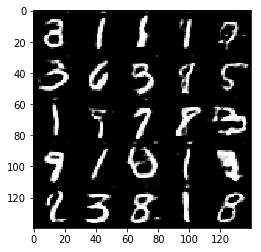

Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.0970... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.7886... Generator Loss: 0.2967
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 2.7996
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.6788
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.5856


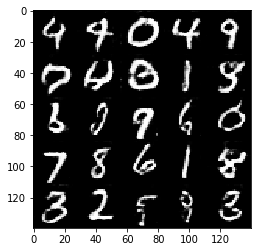

Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 1.9443... Generator Loss: 0.3145
Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.3354
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 0.8915
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 0.8861
Epoch 1/2... Discriminator Loss: 2.1200... Generator Loss: 0.2360
Epoch 1/2... Discriminator Loss: 1.6740... Generator Loss: 0.3609
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 1.8957... Generator Loss: 0.3161


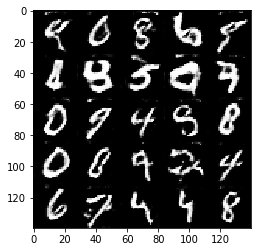

Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.5404
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 2.1649... Generator Loss: 0.2037
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.3102
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.9794
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.6782
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.9454... Generator Loss: 0.2677


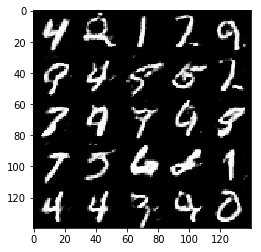

Epoch 1/2... Discriminator Loss: 1.9413... Generator Loss: 0.3195
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.5674
Epoch 1/2... Discriminator Loss: 0.8655... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 2.0146... Generator Loss: 0.2886
Epoch 1/2... Discriminator Loss: 0.8320... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 3.0766... Generator Loss: 0.1104
Epoch 2/2... Discriminator Loss: 1.8510... Generator Loss: 0.2886


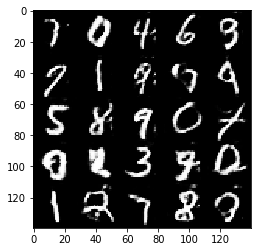

Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 2.0809... Generator Loss: 0.2300
Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.4042
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.4814
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.1161
Epoch 2/2... Discriminator Loss: 1.4793... Generator Loss: 0.5249
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.7743


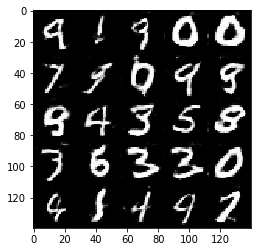

Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.2203
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.6572... Generator Loss: 0.3733
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 1.2789... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.8121
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.9997


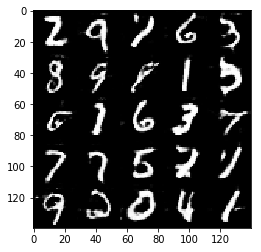

Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 1.8613... Generator Loss: 0.2988
Epoch 2/2... Discriminator Loss: 1.6569... Generator Loss: 0.3464
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.4399
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.7103... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 2.1388... Generator Loss: 0.2230


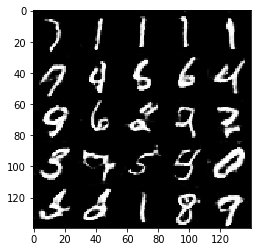

Epoch 2/2... Discriminator Loss: 1.9220... Generator Loss: 0.3179
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.5388... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 0.6367... Generator Loss: 1.5662
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.6803... Generator Loss: 0.3733
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.5164... Generator Loss: 0.3936
Epoch 2/2... Discriminator Loss: 1.6553... Generator Loss: 3.7080
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.6138


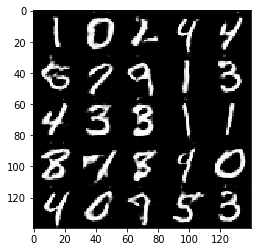

Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 1.9800... Generator Loss: 0.2704
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 1.3653
Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 1.5644
Epoch 2/2... Discriminator Loss: 1.7535... Generator Loss: 0.3794
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 2.5932... Generator Loss: 0.1652


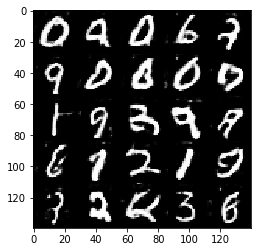

Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.4878
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.6019
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.9448... Generator Loss: 0.2889
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.8670


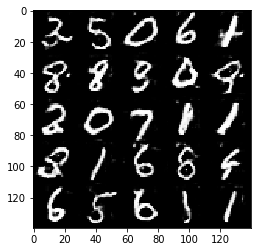

Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 2.7611... Generator Loss: 0.1328
Epoch 2/2... Discriminator Loss: 0.7709... Generator Loss: 1.1649
Epoch 2/2... Discriminator Loss: 1.7708... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 0.6710... Generator Loss: 1.7066


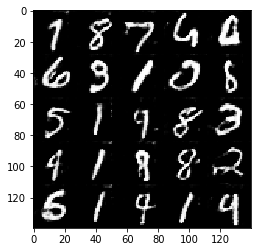

Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 0.6684
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 1.2443... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 0.9765... Generator Loss: 0.9086
Epoch 2/2... Discriminator Loss: 1.9817... Generator Loss: 0.3802
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 0.9605
Epoch 2/2... Discriminator Loss: 0.9342... Generator Loss: 1.8044
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 1.6506


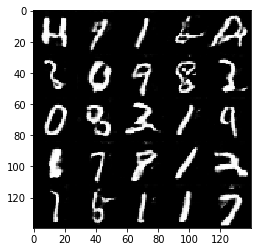

Epoch 2/2... Discriminator Loss: 1.8464... Generator Loss: 0.2831
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 1.5813... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 0.8581... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.6298
Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.5223
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.4850
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.1738


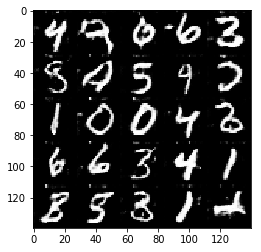

Epoch 2/2... Discriminator Loss: 2.8654... Generator Loss: 0.1192
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 2.0902... Generator Loss: 0.2718
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 1.0694... Generator Loss: 0.7081


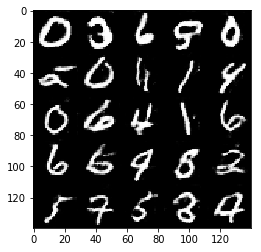

Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.5267... Generator Loss: 2.3401
Epoch 2/2... Discriminator Loss: 2.7707... Generator Loss: 0.1390
Epoch 2/2... Discriminator Loss: 2.4100... Generator Loss: 0.2033
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 3.0657... Generator Loss: 0.0913
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.7114... Generator Loss: 1.4331
Epoch 2/2... Discriminator Loss: 1.0702... Generator Loss: 0.7526


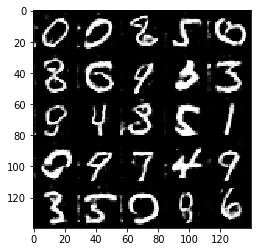

Epoch 2/2... Discriminator Loss: 0.5193... Generator Loss: 2.1518
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 0.9527... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 0.7141
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 1.0652
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 2.1973... Generator Loss: 0.2026
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.6091


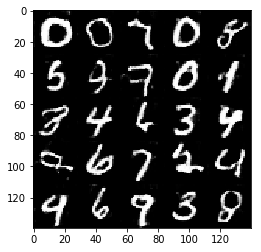

Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.1469
Epoch 2/2... Discriminator Loss: 1.6254... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 0.7310... Generator Loss: 1.6929
Epoch 2/2... Discriminator Loss: 0.6047... Generator Loss: 1.6139
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.2306


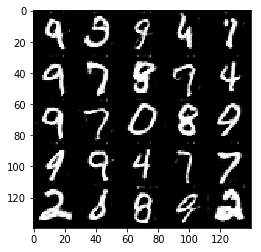

Epoch 2/2... Discriminator Loss: 2.5007... Generator Loss: 0.1458
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.3898... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 1.8255... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.0854
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.1776
Epoch 2/2... Discriminator Loss: 1.1462... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.4971


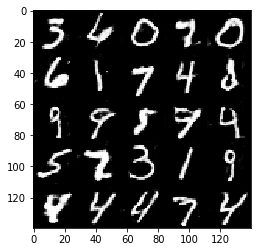

Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 1.8410
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.8232... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 1.5335
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.3847
Epoch 2/2... Discriminator Loss: 1.1782... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.1063


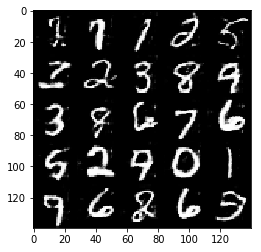

Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 2.4931... Generator Loss: 0.1729
Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 1.6350
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 2.0421
Epoch 2/2... Discriminator Loss: 2.1873... Generator Loss: 0.2268
Epoch 2/2... Discriminator Loss: 2.4433... Generator Loss: 0.2400
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 2.3292... Generator Loss: 0.1962
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.2284


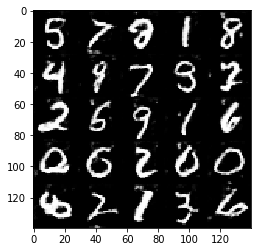

Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.4377
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.0630
Epoch 2/2... Discriminator Loss: 1.9169... Generator Loss: 0.2698
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 1.0876... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.9263
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 2.5110


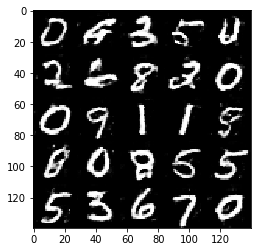

Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 0.4353
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 0.6886... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.9741
Epoch 2/2... Discriminator Loss: 2.5276... Generator Loss: 0.2253
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 0.5157... Generator Loss: 1.9202
Epoch 2/2... Discriminator Loss: 1.4543... Generator Loss: 1.9424


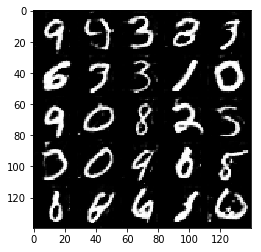

Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.4662
Epoch 2/2... Discriminator Loss: 2.1520... Generator Loss: 0.2326
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 1.6732
Epoch 2/2... Discriminator Loss: 0.4679... Generator Loss: 2.4786


In [73]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 5.4164
Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 4.6541
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 2.1399
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 2.6931... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 3.6996... Generator Loss: 0.0413
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.3395


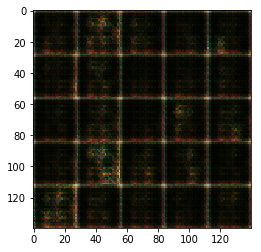

Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.7884
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 3.1057
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 2.6612
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 2.1324
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.5686


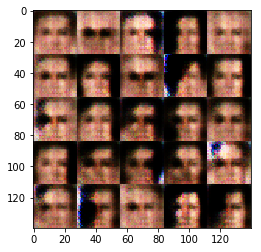

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.7986
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.8765... Generator Loss: 0.2817


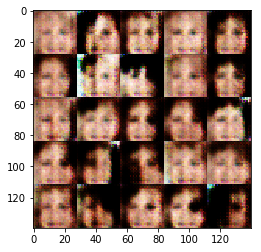

Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 2.2257
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.8059
Epoch 1/1... Discriminator Loss: 1.9232... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 2.5251
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.2191
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.3493


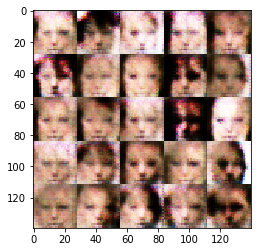

Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 3.2692
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.4570


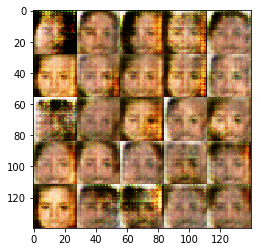

Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 2.4876... Generator Loss: 0.1781
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.5035


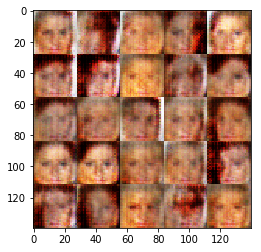

Epoch 1/1... Discriminator Loss: 2.1695... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.6778
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 2.9700
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7054


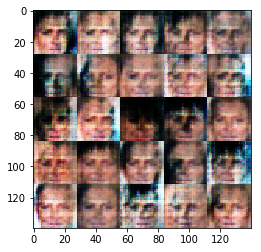

Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 2.0044... Generator Loss: 0.2277
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.4649
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 2.4045
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 4.3538


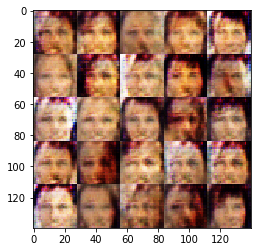

Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 2.0634... Generator Loss: 0.2269
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 2.0309
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.4506
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 1.5231


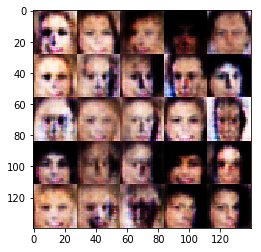

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 3.1435
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.9322
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 0.2787
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 2.3463... Generator Loss: 4.7290


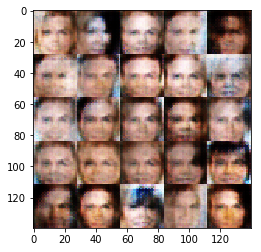

Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 2.0471... Generator Loss: 0.2318


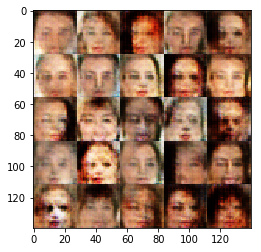

Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 2.1238
Epoch 1/1... Discriminator Loss: 2.0673... Generator Loss: 0.2487
Epoch 1/1... Discriminator Loss: 1.6906... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 3.7433
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.8678... Generator Loss: 4.2002
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 2.5332
Epoch 1/1... Discriminator Loss: 2.4280... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.4500


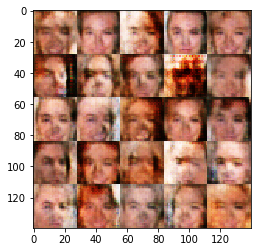

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.3384
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 3.1108
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 3.9281
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.3356


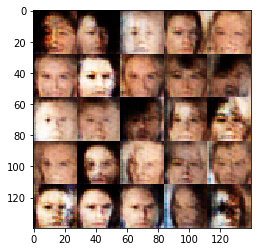

Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.1385
Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 2.8149
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 3.1900


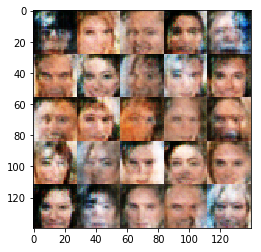

Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 3.5103
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 2.2211
Epoch 1/1... Discriminator Loss: 2.3481... Generator Loss: 0.1675
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.1541


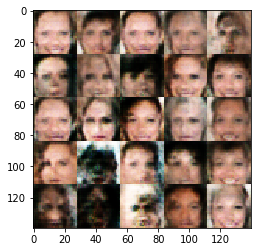

Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 2.0577
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 3.9277
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.2390
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.9205
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.8401


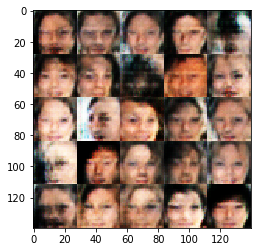

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.7174... Generator Loss: 0.3186
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 2.4427
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.1255


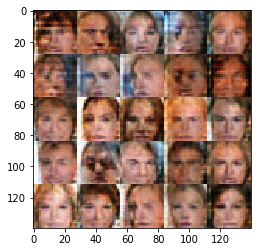

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.8352... Generator Loss: 3.7066
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.1759
Epoch 1/1... Discriminator Loss: 2.2446... Generator Loss: 0.1813


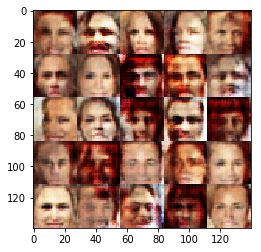

Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.6247


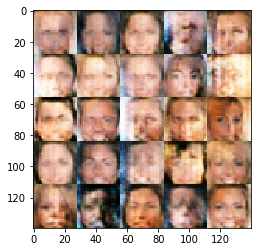

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 2.3558... Generator Loss: 0.1735
Epoch 1/1... Discriminator Loss: 2.2027... Generator Loss: 0.1998


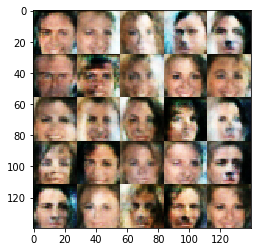

Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 2.0799
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.3428
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 2.1593


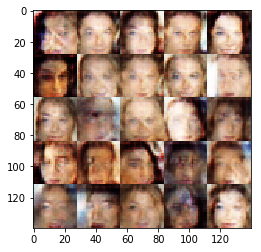

Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 2.5400
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.7895
Epoch 1/1... Discriminator Loss: 2.2976... Generator Loss: 0.1853


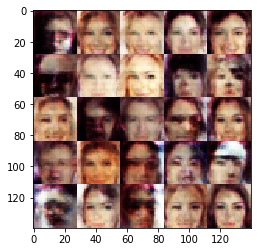

Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.8964


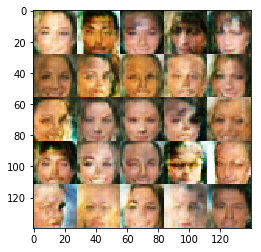

Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 2.1712
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.3996
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8076


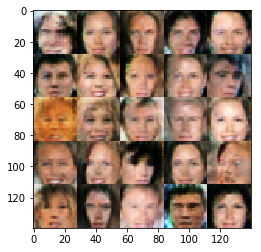

Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.4964
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.9834


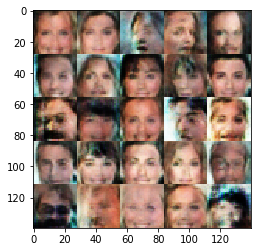

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 2.6331
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.7430... Generator Loss: 0.3169
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 2.0102
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.4101


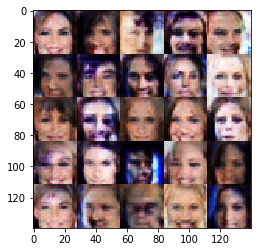

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.5137
Epoch 1/1... Discriminator Loss: 0.6503... Generator Loss: 1.9735
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.3977


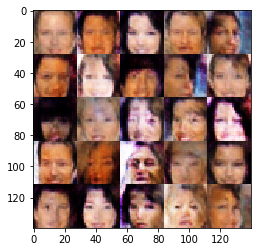

Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.4168
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 2.5701
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 1.5125
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.8998


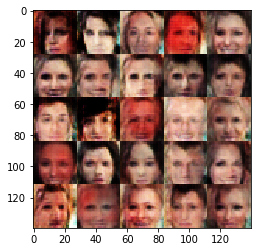

Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.4525
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 2.3581
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 2.1127... Generator Loss: 0.2325
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.6574


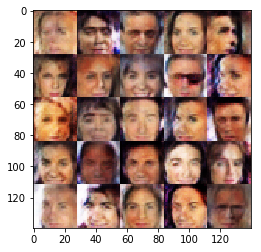

Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.7067


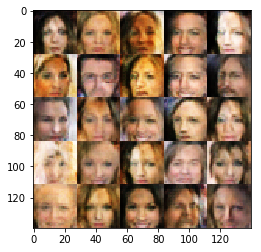

Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 2.3148
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4444


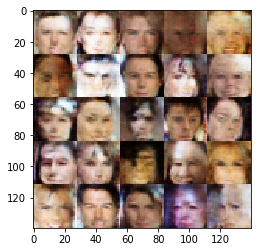

Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.6685
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.0896


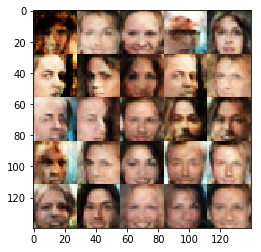

Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.8019


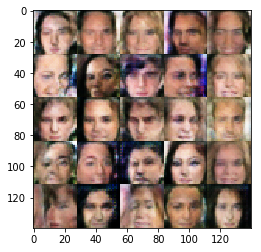

Epoch 1/1... Discriminator Loss: 1.6245... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.7361
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 2.1662


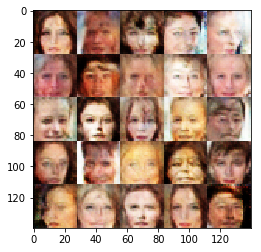

Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.9228... Generator Loss: 0.2514


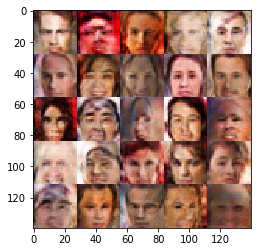

Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.8782
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 2.5656
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 2.1305
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 1.9258... Generator Loss: 0.2614
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 2.2007


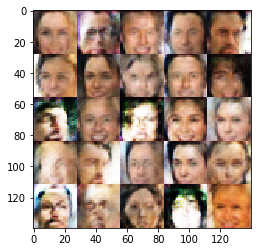

Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 2.4885
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.4645


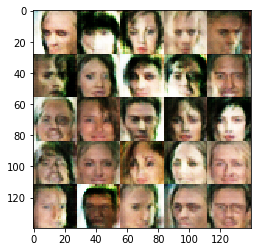

Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.9208
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.5661
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.0182


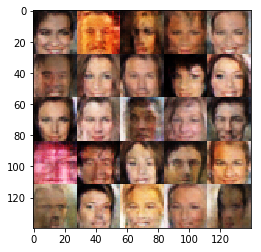

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4105


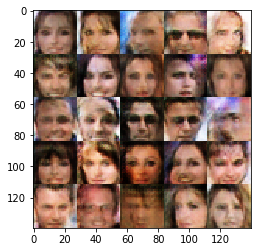

Epoch 1/1... Discriminator Loss: 1.7204... Generator Loss: 0.3397
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.8946


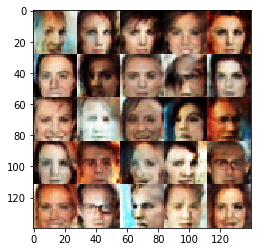

Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.6291
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.6647


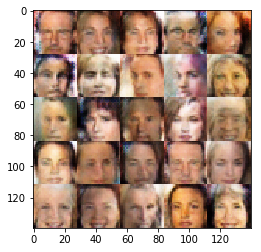

Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 0.8294... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.8482
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.8200
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.6549... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 2.4552
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.1286


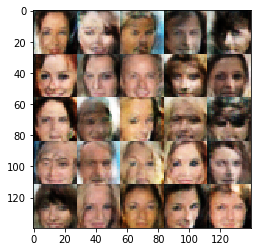

Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.9483
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.6822
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 3.1363
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.0397


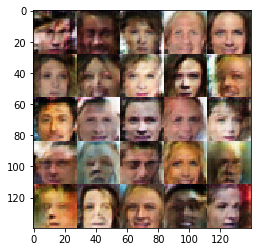

Epoch 1/1... Discriminator Loss: 1.7648... Generator Loss: 0.3455
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.3687
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.3919
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3825


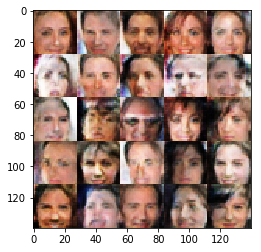

Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 2.0292... Generator Loss: 0.2403
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.2380


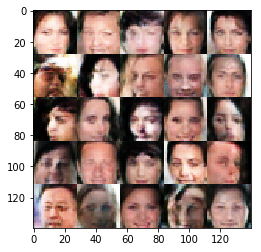

Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7122


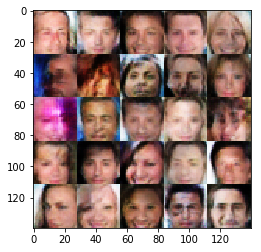

Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 2.0790... Generator Loss: 0.2129
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.8234... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.4898


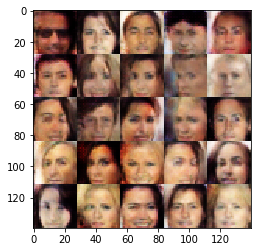

Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.9127
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.3188
Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.8515


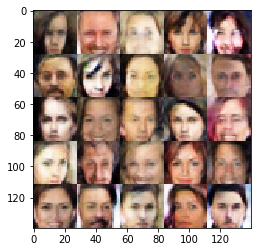

Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.3105
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 2.0691
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.4009


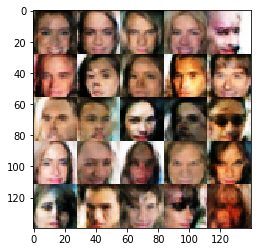

Epoch 1/1... Discriminator Loss: 1.7988... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.9616... Generator Loss: 0.2650
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.3579


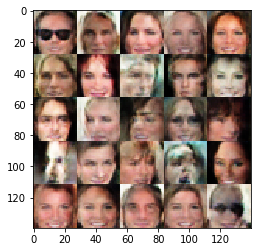

Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6781


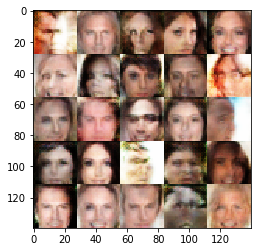

Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.3404
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0951
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.1346


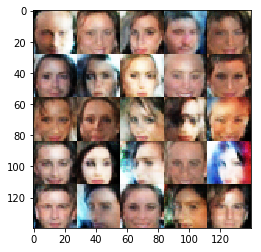

Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 2.5747... Generator Loss: 0.1352
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 2.0690
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.5581


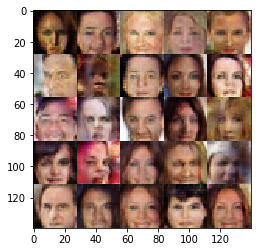

Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 2.1327... Generator Loss: 0.2427
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.7808
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5116


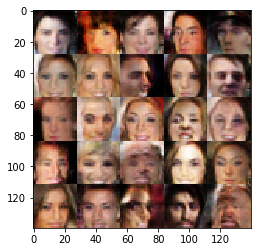

Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.2772
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.8290


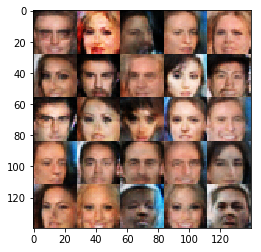

Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 2.2756
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.5879
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.3788
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.4827


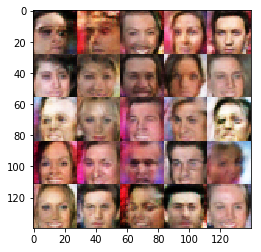

Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.3375
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.8914


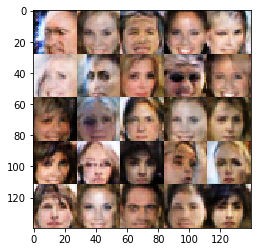

Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.9835... Generator Loss: 0.2649
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.9433


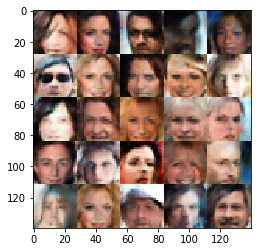

Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 2.2773... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 1.6294... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6298


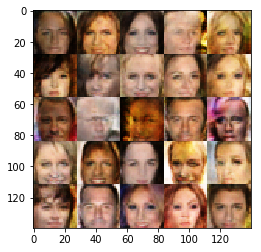

Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.3657
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.9494... Generator Loss: 0.2503
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.3894
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.7070


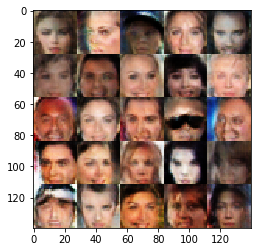

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 2.5370
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.3224
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.7340... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.5039


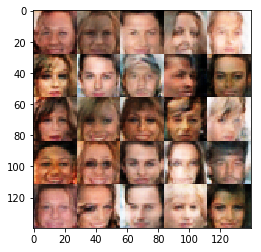

Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.8201


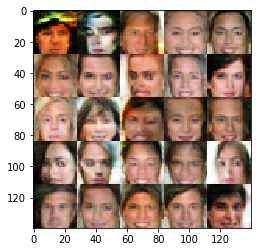

Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.6124
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 0.2881
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.3277
Epoch 1/1... Discriminator Loss: 1.9131... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.3335
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.0396


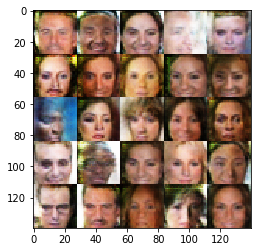

Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 2.4451


In [74]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。